In [8]:
import numpy as np
import matplotlib.pyplot as plt
from math import erf, sqrt, exp, log

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from math import erf, sqrt, exp, log

# ========== basics ==========
def norm_cdf(x):
    return 0.5*(1.0 + erf(x / sqrt(2.0)))

def black_scholes_price(S, K, T, r, sigma, option='call'):
    """Closed-form Black–Scholes (benchmark; not used by solver)."""
    if T <= 0:
        return max(S - K, 0.0) if option == 'call' else max(K - S, 0.0)
    d1 = (log(S/K) + (r + 0.5*sigma*sigma)*T) / (sigma*sqrt(T))
    d2 = d1 - sigma*sqrt(T)
    if option == 'call':
        return S*norm_cdf(d1) - K*exp(-r*T)*norm_cdf(d2)
    else:
        return K*exp(-r*T)*norm_cdf(-d2) - S*norm_cdf(-d1)

# ========== PSOR (obstacle solver) ==========
def psor_lcp_tridiag(lower, diag, upper, b, payoff, w=1.4, tol=1e-8, itmax=20000):
    """
    Projected SOR for an LCP with tridiagonal A (lower, diag, upper).
    Solve v >= payoff, A v >= b, and complementarity holds.
    lower, upper: length n-1 ; diag,b,payoff: length n.
    """
    n = len(diag)
    v = np.maximum(payoff.copy(), 0.0)
    for _ in range(itmax):
        err = 0.0
        # i = 0
        r = b[0] - (diag[0]*v[0] + upper[0]*v[1])
        v_new = max(v[0] + w * r / diag[0], payoff[0])
        err = max(err, abs(v_new - v[0]))
        v[0] = v_new
        # 0 < i < n-1
        for i in range(1, n-1):
            r = b[i] - (lower[i-1]*v[i-1] + diag[i]*v[i] + upper[i]*v[i+1])
            v_new = max(v[i] + w * r / diag[i], payoff[i])
            err = max(err, abs(v_new - v[i]))
            v[i] = v_new
        # i = n-1
        r = b[-1] - (lower[-1]*v[-2] + diag[-1]*v[-1])
        v_new = max(v[-1] + w * r / diag[-1], payoff[-1])
        err = max(err, abs(v_new - v[-1]))
        v[-1] = v_new
        if err < tol:
            break
    return v


FD American price: 19.32672629483749
BS European reference: 0.18616517614119354


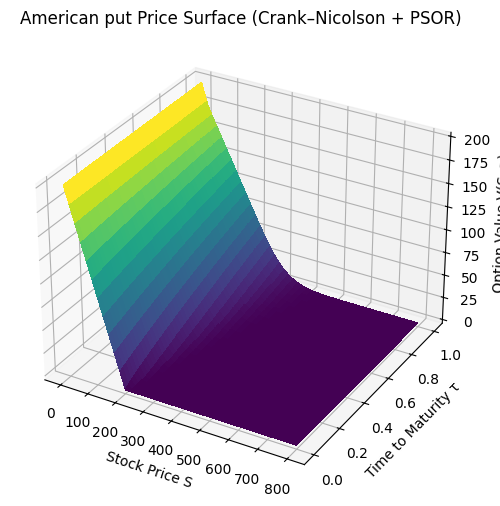

In [40]:
# ========== American CN + PSOR solver ==========
def crank_nicolson_american(S0, K, T, r, sigma, Smax, M, N, option='put', q=0.0):
    """
    American option via Crank–Nicolson time stepping + PSOR obstacle solve.
    Returns: (value_at_S0, V_grid, S_grid, t_grid)
    V_grid shape: (N+1, M+1) with rows=time (from T->0), cols=S.
    """
    # grids
    dS = Smax / M
    S  = np.linspace(0.0, Smax, M+1)
    dt = T / N
    t  = np.linspace(0.0, T, N+1)        # calendar time
    tau = 0.0                             # time-to-maturity carried for BCs
    V  = np.zeros((N+1, M+1))

    # terminal payoff at maturity (row 0 corresponds to tau=0)
    if option == 'call':
        V[0, :] = np.maximum(S - K, 0.0)
    else:
        V[0, :] = np.maximum(K - S, 0.0)

    # operator coefficients at interior nodes i=1..M-1
    a = np.zeros(M-1); b = np.zeros(M-1); c = np.zeros(M-1)
    for i in range(1, M):
        Si = S[i]
        A = 0.5 * sigma*sigma * Si*Si
        B = (r - q) * Si
        a[i-1] = A / (dS**2) - B / (2*dS)
        b[i-1] = -2*A / (dS**2) - r
        c[i-1] = A / (dS**2) + B / (2*dS)

    # CN diagonals: left (implicit) and right (explicit)
    alpha_L = -0.5 * dt * a
    beta_L  =  1.0  - 0.5 * dt * b
    gamma_L = -0.5 * dt * c
    alpha_R =  0.5 * dt * a
    beta_R  =  1.0  + 0.5 * dt * b
    gamma_R =  0.5 * dt * c

    payoff = V[0, :].copy()  # obstacle

    def apply_boundaries(col, tau_now):
        if option == 'call':
            col[0]  = 0.0
            # simple right BC; if q>0, you can use S*e^{-q tau} - K e^{-r tau}
            col[-1] = (S[-1] - K*exp(-r*tau_now)) if q==0 else (S[-1]*exp(-q*tau_now) - K*exp(-r*tau_now))
        else:
            col[0]  = K
            col[-1] = 0.0

    # march backward in time
    for n in range(0, N):
        tau_new = tau + dt
        prev = V[n, :]

        # RHS = (I + 0.5 dt L) * V_old, interior nodes 1..M-1
        rhs = np.empty(M-1)
        for i in range(1, M):
            rhs[i-1] = alpha_R[i-1]*prev[i-1] + beta_R[i-1]*prev[i] + gamma_R[i-1]*prev[i+1]

        # boundary values at new time on the implicit side
        bc = np.zeros(M+1)
        apply_boundaries(bc, tau_new)
        rhs[0]  -= alpha_L[0]  * bc[0]     # left boundary contribution
        rhs[-1] -= gamma_L[-1] * bc[-1]    # right boundary contribution

        # Solve LCP on interior (1..M-1) with A = I - 0.5 dt L  (tridiagonal)
        lower = alpha_L[1:]
        diag  = beta_L
        upper = gamma_L[:-1]
        payoff_int = payoff[1:M]

        v_int = psor_lcp_tridiag(lower, diag, upper, rhs, payoff_int, w=1.4, tol=1e-8, itmax=20000)

        # write column and apply BCs
        V[n+1, 1:M] = v_int
        V[n+1, 0]   = bc[0]
        V[n+1, -1]  = bc[-1]
        tau = tau_new

    # interpolate value at S0 from final row (today)
    if S0 <= 0:
        val = V[-1, 0]
    elif S0 >= Smax:
        val = V[-1, -1]
    else:
        i = int(S0 / dS)
        val = V[-1, i] + (V[-1, i+1] - V[-1, i]) * (S0 - S[i]) / dS

    return val, V, S, t

if __name__ == '__main__':
    S0 = 300.0; K = 200.0; T = 1.0; r = 0.05; sigma = 0.2
    Smax = 4*K
    M = 400   # space steps
    N = 800   # time steps
    option = 'put'  # try 'put' to see early exercise effect
    div = 0.5 # continuous dividend yield

    price_fd, V_grid, S_grid, t_grid = crank_nicolson_american(
        S0, K, T, r, sigma, Smax, M, N, option=option, q=div
    )

    print("FD American price:", price_fd)
    # Reference (equals European if call with q=0)
    print("BS European reference:", black_scholes_price(S0, K, T, r, sigma, option=option))

    # --- Plot (use τ = time-to-maturity) ---
    tau_grid = np.linspace(0.0, T, N+1)       # rows of V_grid correspond to τ increasing 0→T
    S_mesh, tau_mesh = np.meshgrid(S_grid, tau_grid)

    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(S_mesh, tau_mesh, V_grid, cmap='viridis', linewidth=0, antialiased=False)
    ax.set_xlabel('Stock Price S')
    ax.set_ylabel('Time to Maturity τ')
    ax.set_zlabel('Option Value V(S, τ)')
    ax.set_title(f'American {option} Price Surface (Crank–Nicolson + PSOR)')
    plt.show()


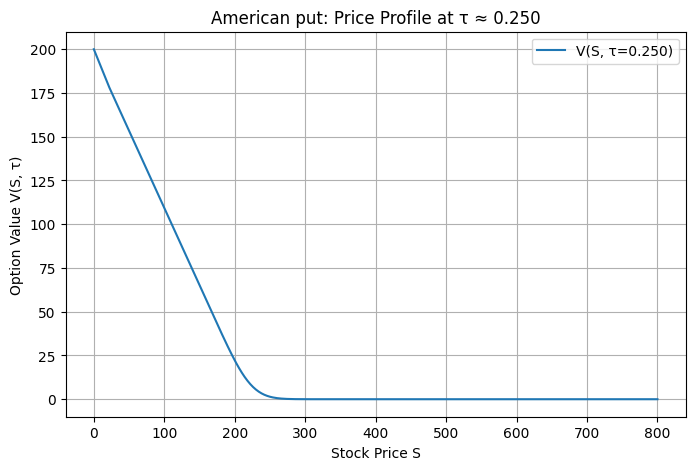

In [41]:
# Choose a time-to-maturity slice
tau_target = 0.25  # years remaining (τ)
tau_grid = np.linspace(0.0, T, N+1)
idx = np.argmin(np.abs(tau_grid - tau_target))

plt.figure(figsize=(8,5))
plt.plot(S_grid, V_grid[idx, :], label=f'V(S, τ={tau_grid[idx]:.3f})')
plt.xlabel('Stock Price S')
plt.ylabel('Option Value V(S, τ)')
plt.title(f'American {option}: Price Profile at τ ≈ {tau_grid[idx]:.3f}')
plt.grid(True)
plt.legend()
plt.show()


In [42]:
import plotly.io as pio
import plotly.graph_objects as go

pio.renderers.default = "browser"  # avoids nbformat renderer issues
tau_grid = np.linspace(0.0, T, N+1)

fig = go.Figure(data=[go.Surface(
    x=S_grid,         # Stock price axis
    y=tau_grid,       # Time-to-maturity axis
    z=V_grid,         # Option values
    colorscale='Viridis',
    contours={"z": {"show": True, "usecolormap": True, "highlightcolor": "limegreen", "project_z": True}}
)])

fig.update_layout(
    title=f'American {option} Price Surface (Crank–Nicolson + PSOR)',
    scene=dict(
        xaxis_title='Stock Price S',
        yaxis_title='Time to Maturity τ',
        zaxis_title='Option Value V(S, τ)',
        xaxis=dict(nticks=8, range=[0, Smax]),
        yaxis=dict(nticks=8, range=[0, T]),
        zaxis=dict(nticks=8),
    ),
    autosize=True,
    width=900,
    height=700,
    margin=dict(l=50, r=50, b=50, t=80),
)

fig.show()


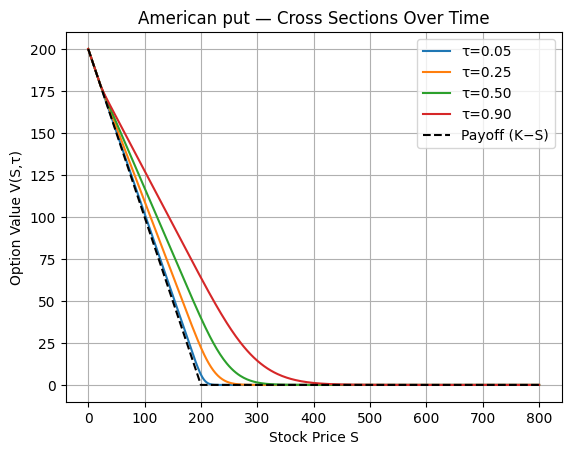

In [43]:
for tau_target in [0.05, 0.25, 0.5, 0.9]:
    idx = np.argmin(np.abs(t_grid - tau_target))
    plt.plot(S_grid, V_grid[idx, :], label=f"τ={tau_target:.2f}")
plt.plot(S_grid, np.maximum(K - S_grid, 0), 'k--', label='Payoff (K−S)')
plt.xlabel("Stock Price S")
plt.ylabel("Option Value V(S,τ)")
plt.legend()
plt.grid(True)
plt.title(f"American {option} — Cross Sections Over Time")
plt.show()

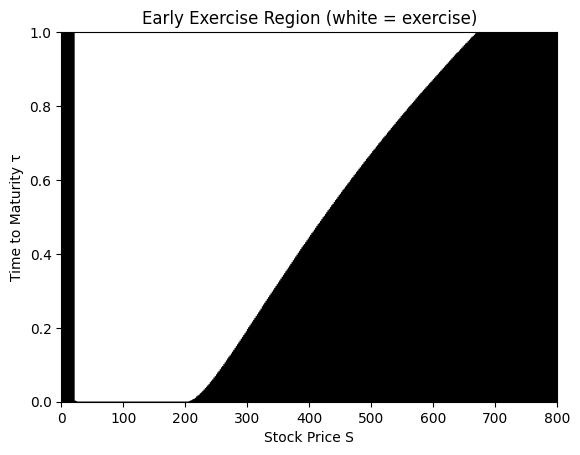

In [44]:
exercise_mask = np.isclose(V_grid, np.maximum(K - S_grid[np.newaxis, :], 0), atol=1e-3)
plt.imshow(exercise_mask[::-1, :], extent=[0, Smax, 0, T], aspect='auto', cmap='Greys')
plt.xlabel("Stock Price S")
plt.ylabel("Time to Maturity τ")
plt.title("Early Exercise Region (white = exercise)")
plt.show()
